In [7]:
import PIL
import re
import six
import math
import os
import lmdb

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display
from keras import layers
from keras.models import Model
from tensorflow.keras.utils import Sequence
from keras import backend as K
from keras.models import load_model

In [12]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [3]:
HOME_DIR = './data/OCR/data_lmdb_release/training/'
TRAIN_DATA_PATH = HOME_DIR+'MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'MJ/MJ_test'
print(TRAIN_DATA_PATH)

./data/OCR/data_lmdb_release/training/MJ/MJ_train


# 데이터 불러오기

orginal image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


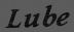

orginal image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


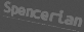

orginal image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


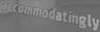

orginal image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


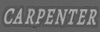

In [10]:
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적임

env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

# 불러온 데이터를 txn(트랜잭션)이라는 변수를 통해 연다
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # 인덱스를 이용해서 라벨 키와 이미지 키를 만든다
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        
        # 이미지를 버퍼를 통해 읽어오기 때문에 이미지로 변환과정
        try:
            img = Image.open(buf).convert('RGB')
        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'
            
        # 원본 이미지 크기를 출력
        width, height = img.size
        print('orginal image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿈, 너비는 100보다 작게
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width, 32)
        print('target_img_size:{}'.format(target_img_size))
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
        
        # 높이가 32로 일정한 이미지와 라벨을 함께 출력
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

## 데이터셋 클래스 만들기

In [38]:
class MJDatasetSequence(Sequence):
    # 객체 초기화 시 lmdb를 열어 env에 준비해두고, 데이터 수 파악
    def __init__(self,
                 dataset_path:str,
                 label_converter:object,
                 batch_size:int=1,
                 img_size:tuple=(100, 32),
                 max_text_len:int=22,
                 is_train:bool=False,
                 character:str=''):
        """
        학습용 데이터셋 반환 클래스

        Args:
            dataset_path (str): 
            label_converter (object): 
            batch_size (int):  Defaults to 1.
            img_size (tuple):  Defaults to (100, 32).
            max_text_len (int):  Defaults to 22.
            is_train (bool):  Defaults to False.
            character (str):  Defaults to ''.

        Returns:
            inputs:
            outputs:
        """
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100
        
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
            
            
    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
        
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)
            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            
            # 이미지를 버퍼를 통해 읽어오기 때문에 이미지로 변환과정
            try:
                img = Image.open(buf).convert('RGB')
            except IOError:
                img = Image.new('RGB', (100, self.img_size))
                label = '-'
                
            # 원본 이미지 크기를 출력
            width, height = img.size
            # print('orginal image width:{}, height:{}'.format(width, height))
            
            # 이미지 비율을 유지하면서 높이를 32로 바꿈, 너비는 100보다 작게
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            # print('target_img_size:{}'.format(target_img_size))
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]
            
        return(img, label)
        
        # 1. idx에 해당하는 index_list만큼 데이터를 불러
        # 2. image와 label을 불러오고
        # 3. 사용하기 좋은 inputs와 outputs 형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.ones([self.batch_size, self.max_text_len], dtype='int64')
        
        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')
        
        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있다
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image' : input_images,
            'label' : labels,
            'input_length' : input_length,
            'label_length' : label_length
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}
        
        return inputs, outputs

## Label Encoder 만들기
* 앞서 만든 데이터셋 클래스에서 나오는 label은 평문 text로 되어있다.
* 따라서 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해주는 과정이 필요하다

In [39]:
class LabelConverter(object):
    def __init__(self, character):
        # 입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장
        # '-'를 공백문자로 활용
        self.character = '-' + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i
    
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)
    
    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ''
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [14]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함된다.

## Loss 계산을 위한 CTC 함수

만약 모델이 AAAAPPPPLLLEEE을 출력했다면 APLE이 결과가 될 것이다. 따라서 이전 단계에서 공백문자를 포함하여 AP-PLE로 보정해 주는 작업이 포함되었던 것이다.  
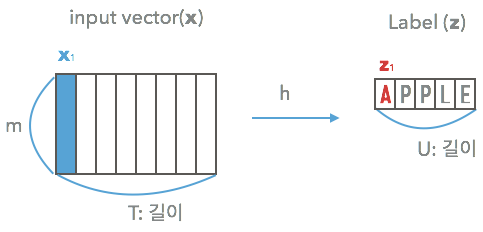

In [15]:
def ctc_lambda_func(args):
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# 모델

In [34]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

# 학습

In [43]:
# 데이터셋과 모델을 준비합니다
label_converter = LabelConverter(TARGET_CHARACTERS)
BATCH_SIZE = 256
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [44]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 32, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 100, 32, 64)  1792        ['input_image[0][0]']            
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 50, 16, 64)  0           ['conv2d_35[0][0]']              
 )                                                                                                
                                                                                            

In [46]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + 'model/mj_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
history = model.fit(train_set,
                    steps_per_epoch=len(train_set),
                    epochs=50,
                    validation_data=val_set,
                    validation_steps=len(val_set),
                    callbacks=[ckp, earlystop])

Epoch 1/50
283/283 [==============================] - ETA: 0s - loss: 24.1954
Epoch 00001: val_loss improved from inf to 23.63424, saving model to ./data/OCR/data_lmdb_release/training/model\mj_checkpoint.hdf5
283/283 [==============================] - 25s 88ms/step - loss: 24.1954 - val_loss: 23.6342
Epoch 2/50
283/283 [==============================] - ETA: 0s - loss: 18.4189
Epoch 00002: val_loss improved from 23.63424 to 15.32042, saving model to ./data/OCR/data_lmdb_release/training/model\mj_checkpoint.hdf5
283/283 [==============================] - 25s 90ms/step - loss: 18.4189 - val_loss: 15.3204
Epoch 3/50
283/283 [==============================] - ETA: 0s - loss: 10.2022
Epoch 00003: val_loss improved from 15.32042 to 9.43464, saving model to ./data/OCR/data_lmdb_release/training/model\mj_checkpoint.hdf5
283/283 [==============================] - 26s 90ms/step - loss: 10.2022 - val_loss: 9.4346
Epoch 4/50
283/283 [==============================] - ETA: 0s - loss: 7.0801
Epoch 

In [47]:
# 모델 불러오기
# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


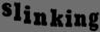

Result: 	 RWANDA999999999999999999


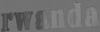

Result: 	 HALLO999999999999999999


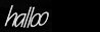

Result: 	 DOWNSIZE9999999999999999


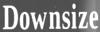

Result: 	 SLOPPY99999999999999999


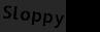

Result: 	 DEARS9999999999999999999


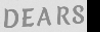

Result: 	 ERAD99999999999999999999


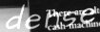

Result: 	 FHUMPACKS999999999999999


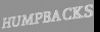

Result: 	 MLWAUKE9999999999999999


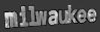

Result: 	 REACTIONARY9999999999999


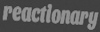

In [48]:
# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

# Project: End-to-End OCR

In [8]:
import PIL
import cv2
import keras_ocr


import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from keras_ocr.detection import Detector
from keras_ocr.recognition import Recognizer

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.7.0
1.22.3
9.4.0
4.7.0
0.9.2


Looking for C:\Users\User\.keras-ocr\craft_mlt_25k.h5


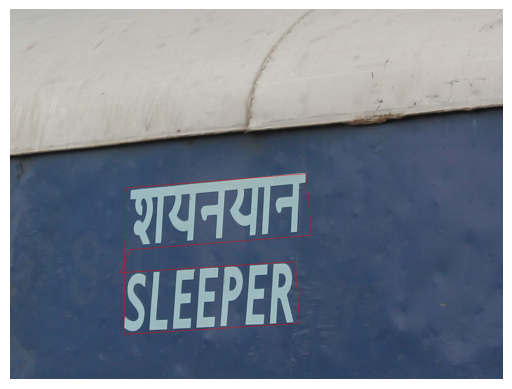

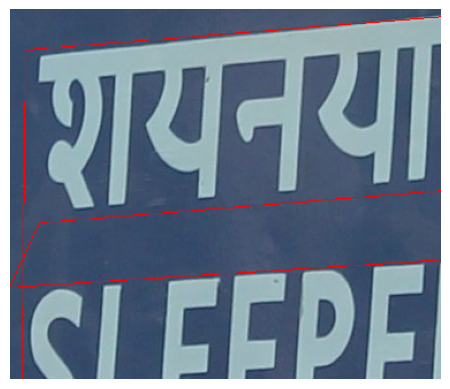

In [35]:
SAMPLE_IMG_PATH = './data/OCR/sample.jpg'
detector = Detector()

def detect_text(img_path):
    img_pil = Image.open(img_path)
    
    # Detection
    ocr_result = detector.detect([img_path])

    # Draw bounding boxes around the detected text regions
    img_draw = ImageDraw.Draw(img_pil)
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:, 0].min()
        x_max = text_result[:, 0].max()
        y_min = text_result[:, 1].min() 
        y_max = text_result[:, 1].max()
        word_box = [x_min, y_min, x_max, y_max]
        cropped_img = img_pil.crop(word_box)
        cropped_imgs.append(cropped_img)

    return img_pil, cropped_imgs

img_pil, cropped_imgs = detect_text(SAMPLE_IMG_PATH)

# Display the resulting image with bounding boxes
plt.imshow(np.array(img_pil))
plt.axis('off')
plt.show()

# Display the cropped images
for cropped_img in cropped_imgs:
    plt.imshow(np.array(cropped_img))
    plt.axis('off')
    plt.show()

글자가 벽면에 약간 기울여 있어서 box로 crop시 잘리는 것으로 보인다.

In [36]:
recognizer = Recognizer()
def recognize_img(pil_img, input_img_size=(100, 32)):
    # Resize the image
    resized_img = pil_img.resize(input_img_size)

    # Convert the image to a numpy array
    img_array = np.array(resized_img)

    word = recognizer.recognize(img_array)

    # Display the recognized word
    print(word)

Looking for C:\Users\User\.keras-ocr\crnn_kurapan.h5


In [37]:
for _img in [cropped_img]:
    recognize_img(_img)

pte


잘리는것도 이상했기 때문에 글자가 잘 인식되지 않는것을 볼 수 있다.